# Analysis / Plotting - Notebook 04 - p_polym
Author: Bettina Vignolo

This notebook was created to perform several smaller experiments with the microtubule model and analyze the results. It focuses on ```p_polym``` and how this parameter influences MT length

In [3]:
# load Packages:
using Agents
using Statistics
using DataFrames
using Distributions
using StatsBase
using DrWatson: @dict
using Serialization
using InteractiveDynamics
using GLMakie
import ColorSchemes as co
using DataFramesMeta

# load Functions:
include("01_Agent.jl")
include("02_Initialization.jl")
include("03_AgentStep.jl")
include("04_ModelStep.jl")
include("05_Analysis.jl")

MT_size_each (generic function with 1 method)

In [20]:
using Distributed
addprocs(4)

@everywhere begin
    # load Packages:
    using Agents
    using Statistics
    using DataFrames
    using Distributions
    using StatsBase
    using DrWatson: @dict
    using Serialization
    using InteractiveDynamics
    using GLMakie
    import ColorSchemes as co
    using DataFramesMeta

    # load Functions:
    include("01_Agent.jl")
    include("02_Initialization.jl")
    include("03_AgentStep.jl")
    include("04_ModelStep.jl")
    include("05_Analysis.jl")
end    

## 1. Scanning for ideal range


### 1.1 First try with 10 different p_polym

In [4]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 4,
            :numagents => 1000, 
            :p_hyd => 0.024,                     #chosen based on Analysis 02               
            :p_polym=> collect([0.0:0.1:1.0]...),    #11 different probabilities   
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => 0.5,               #chosen based on Analysis 01  
            :p_GTP_exchange => 0.01              #chosen based on Analysis 03
    )
# Model Data:
mdata = [mean_MT_size]
# Run Model 
_ , paramdata = paramscan(parameters, initialize; mdata, agent_step!, model_step!, n=10000)
serialize("data/paramscan_p_polym_10kSteps.jls", paramdata)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


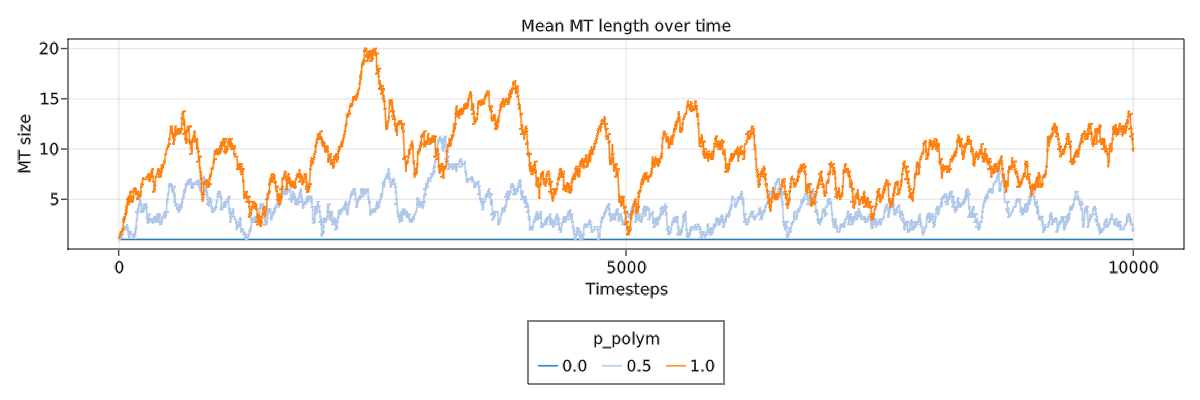

In [9]:
data1 = deserialize("data/paramscan_p_polym_10kSteps.jls"); #110.011 rows
f1 = Figure(resolution =(1200, 400))
ax1 = Axis(f1[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time")
range = collect(0.0:0.5:1.0)

for (i,v) in enumerate(range)
    sub_data = @subset(data1, :p_polym .== v)
    lines!(ax1, sub_data.step, sub_data.mean_MT_size, label = "$v", color = co.tab20[i])
end


Legend(f1[2,1], ax1, "p_polym", orientation = :horizontal, tellwidth = false, tellheight = true)

f1

### 1.2 Repeat with p_depolym_GDP = 0.1

In [16]:
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 4,
            :numagents => 1000, 
            :p_hyd => 0.024,                     #chosen based on Analysis 02               
            :p_polym=> collect([0.0:0.1:1.0]...),    #11 different probabilities   
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => 0.1,               #chosen to see the effect of p_polym  
            :p_GTP_exchange => 0.01              #chosen based on Analysis 03
    )
# Model Data:
mdata = [mean_MT_size]
# Run Model 
_ , paramdata = paramscan(parameters, initialize; mdata, agent_step!, model_step!, n=10000)
serialize("data/paramscan_p_polym_10kSteps_01p_depolym_GDP.jls", paramdata)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


In [18]:
data1_2 = deserialize("data/paramscan_p_polym_10kSteps_01p_depolym_GDP.jls"); #110.011 rows

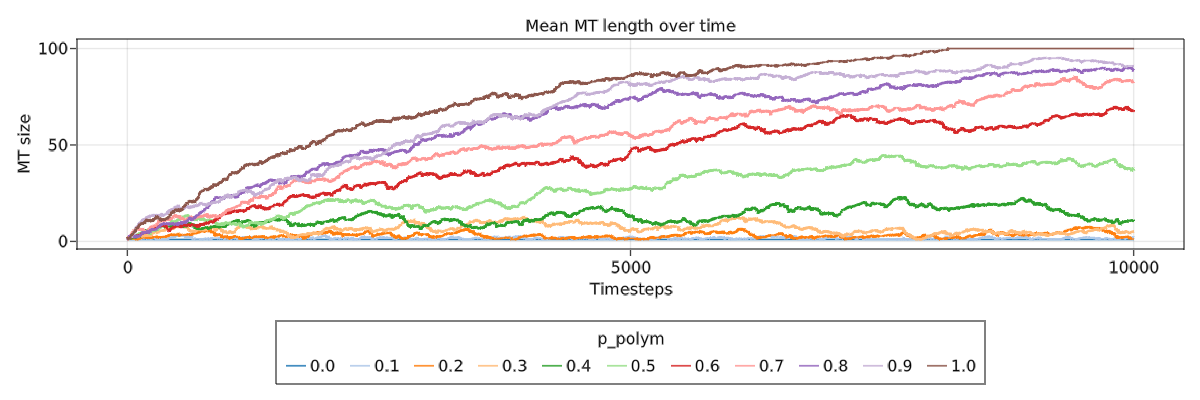

In [19]:
f1_2 = Figure(resolution =(1200, 400))
ax1_2 = Axis(f1_2[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time")
range = collect(0.0:0.1:1.0)

for (i,v) in enumerate(range)
    sub_data = @subset(data1_2, :p_polym .== v)
    lines!(ax1_2, sub_data.step, sub_data.mean_MT_size, label = "$v", color = co.tab20[i])
end


Legend(f1_2[2,1], ax1_2, "p_polym", orientation = :horizontal, tellwidth = false, tellheight = true)

f1_2

### 1.3 Repeat 1.2 but 10x longer and with 10 ensembles
runtime 172 min (w/o parallelization)

In [22]:
@everywhere begin
    models = [initialize(;
            Nstarts = 4,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = x,
            p_hyd = 0.024,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.1)  
        for x in repeat(collect([0.0:0.1:1.0]...), 10)]

    mdata = [mean_MT_size, (:p_polym)]
    mlabels = ["mean MT length", "p_polym"]
end
data_ens = ensemblerun!(models, agent_step!, model_step!, 100000; mdata)
serialize("data/paramscan_p_polym_10ensemble_100kSteps.jls", data_ens[2])

In [16]:
data1_3 = deserialize("data/paramscan_p_polym_10ensemble_100kSteps.jls")
gdf = groupby(@subset(data1_3, :ensemble .!= 88, :ensemble .!= 86), [:step, :p_polym]) #
sum_1_3 = combine(gdf, [:mean_MT_size] .=> [mean]);

In [20]:
#MT length over time
f1_3 = Figure(resolution =(1200, 600))
ax1_3 = Axis(f1_3[1,1]; xlabel = "Timesteps", ylabel = "MT size", title = "Mean MT length over time (10x ensemble) - excluded ensemble 86, 88")
range = collect(0.0:0.1:1.0)

for (i,v) in enumerate(range)
    sub_data = @subset(sum_1_3, :p_polym .== v)
    lines!(ax1_3, sub_data.step, sub_data.mean_MT_size_mean, label = "$v", color = co.tab20[i])
end


Legend(f1_3[2,1], ax1_3, "p_polym", orientation = :horizontal, tellwidth = false, tellheight = true)

display(f1_3)

GLMakie.Screen(...)

In [18]:
@subset(data1_3, :p_polym .== 0.8, :step .== 50000);

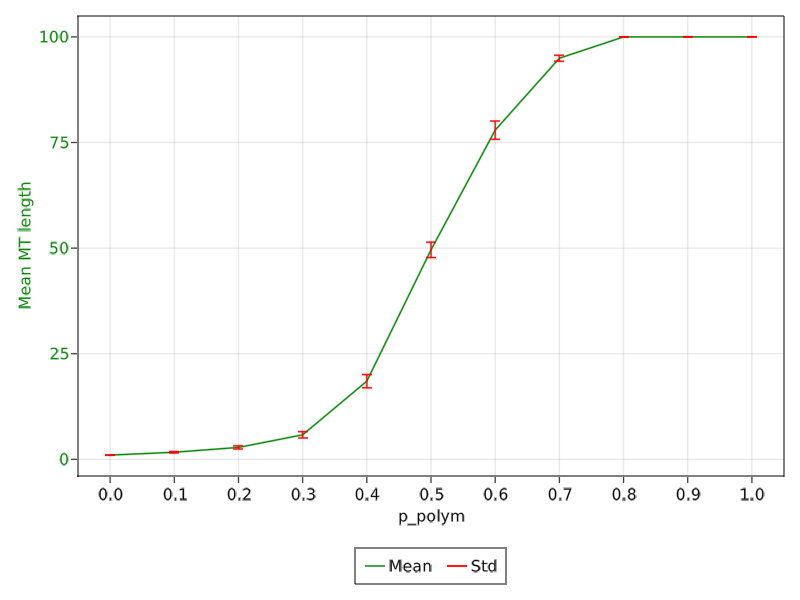

In [21]:
#Mean Length
f2_3 = Figure(resolution = (800, 600)) 
range = collect(0.0:0.1:1.0)

ax2_3 = Axis(f2_3[1,1]; titel = "Avg of MT lengths", xlabel = "p_polym", ylabel ="Mean MT length", xticks = LinearTicks(11), yticks = LinearTicks(5), yticklabelcolor = :green,  ylabelcolor = :green)

means = Float64[]
stds = Float64[]
for (i,v) in enumerate(range)
    df_sub = @subset(sum_1_3, :step .>= 50000, :p_polym .== v)  
    append!(means, mean(df_sub.mean_MT_size_mean))
    append!(stds, std(df_sub.mean_MT_size_mean))
end

l1 = lines!(ax2_3, range, means, color = :green)
l2 = errorbars!(ax2_3, range, means, stds, color = :red, whiskerwidth = 10)

Legend(f2_3[2,1], [l1, l2], ["Mean", "Std"], orientation = :horizontal, tellwidth = false, tellheight = true)

f2_3

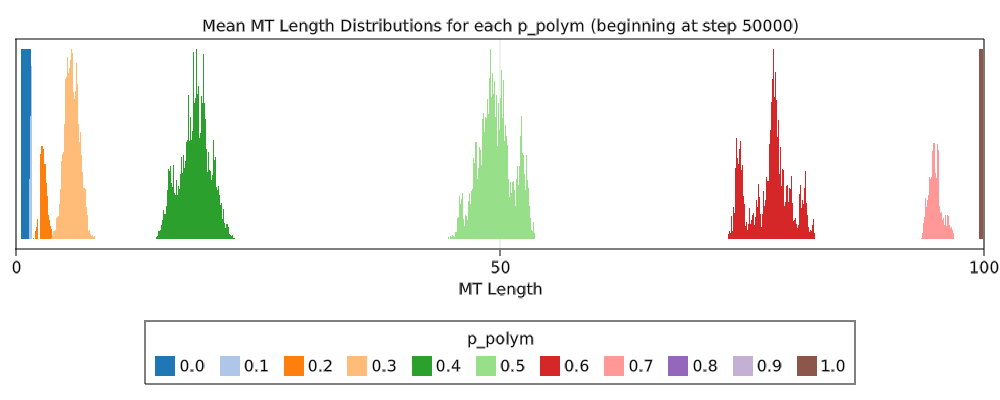

In [22]:
#Histogramm
f2_8 = Figure(resolution = (1000, 400)) 
range = collect(0.0:0.1:1.0)
ax2_8 = Axis(f2_8[1,1]; xlabel = "MT Length", title = "Mean MT Length Distributions for each p_polym (beginning at step 50000)")
hideydecorations!(ax2_8)
xlims!(ax2_8, 0, 100)

for (i,v) in enumerate(range)
    df_sub = @subset(sum_1_3, :step .>= 50000, :p_polym .== v) 
    hist!(ax2_8, df_sub.mean_MT_size_mean; bins = 100, scale_to=0.003, direction=:y, label = "$v", color = co.tab20[i])
end

Legend(f2_8[2,1], ax2_8, "p_polym", merge = true, orientation = :horizontal, tellwidth = false, tellheight = true)

f2_8